# Applying Linear Regression Model to Predict House Sale Prices in Ames, Iowa

This project is a part of the Dataquest guided project. I also do further work and analysis on my own. The data used for this project is mentioned here https://www.tandfonline.com/doi/abs/10.1080/10691898.2011.11889627. The housing data is for Ames, Iowa from 2006 to 2010, and the information of individual columns containing in this dataset is explained here https://s3.amazonaws.com/dq-content/307/data_description.txt.

This project aims to predict the sale prices of the houses in Ames, Iowa using the linear regression model.

In [331]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import KFold

%matplotlib inline

## 1. Import the Dataset

In [332]:
ames = pd.read_csv("AmesHousing.tsv", sep = '\t')
ames.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


## 2. Feature Engineering

### 2.1 Drop the columns with > 5% missing values


In [333]:
ames_null = ames.isnull().sum()*100/len(ames)
ames_5pct_null = ames_null[ames_null > 5]
ames_5pct_null


Lot Frontage     16.723549
Alley            93.242321
Fireplace Qu     48.532423
Garage Type       5.358362
Garage Yr Blt     5.426621
Garage Finish     5.426621
Garage Qual       5.426621
Garage Cond       5.426621
Pool QC          99.556314
Fence            80.477816
Misc Feature     96.382253
dtype: float64

In [334]:
ames.drop(columns=ames_5pct_null.index, inplace=True)
ames.columns

Index(['Order', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Area', 'Street',
       'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope',
       'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type',
       'House Style', 'Overall Qual', 'Overall Cond', 'Year Built',
       'Year Remod/Add', 'Roof Style', 'Roof Matl', 'Exterior 1st',
       'Exterior 2nd', 'Mas Vnr Type', 'Mas Vnr Area', 'Exter Qual',
       'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2',
       'Bsmt Unf SF', 'Total Bsmt SF', 'Heating', 'Heating QC', 'Central Air',
       'Electrical', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF',
       'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath',
       'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual',
       'TotRms AbvGrd', 'Functional', 'Fireplaces', 'Garage Cars',
       'Garage Area', 'Paved Drive', 'Wood Deck SF', 'Open Porch SF',
 

### 2.2 Drop any text columns with 1 or more missing values

In [335]:
text_col_null = ames.select_dtypes(include = ['object']).isnull().sum()
text_col_null = text_col_null[text_col_null > 0]
text_col_null

Mas Vnr Type      23
Bsmt Qual         80
Bsmt Cond         80
Bsmt Exposure     83
BsmtFin Type 1    80
BsmtFin Type 2    81
Electrical         1
dtype: int64

In [336]:
ames.drop(columns=text_col_null.index, inplace=True)

### 2.3 Replace null values in any numerical columns with the most common value for that column

In [337]:
numerical_col = ames.select_dtypes(include = ['int', 'float'])
numerical_null_col = ames.isnull().sum() > 0
numerical_null_col = numerical_null_col[numerical_null_col]
numerical_null_col.index

Index(['Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF',
       'Total Bsmt SF', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Garage Cars',
       'Garage Area'],
      dtype='object')

In [338]:
for col in numerical_null_col.index:
    ames[col].fillna(ames[col].mode()[0], inplace=True)

In [339]:
# check if any columns with null
ames.isnull().sum().value_counts()

0    64
dtype: int64

### 2.4 Create new feature that better capture the information in the existing features

In [340]:
# years sold after remodify the houses: this value will be calculated from the differences between 'Yr Sold' and 'Year Remod/Add' columns.
ames['years_after_remod'] = ames['Yr Sold'] - ames['Year Remod/Add']

# drop the column with negative years after remodify
ames.drop(ames[ames['years_after_remod'] < 0].index, inplace = True)


In [341]:
# years that the houses were sold after they were built
ames['years_bf_sale'] = ames['Yr Sold'] - ames['Year Built']

# drop the column with negaitive years before sale
ames.drop(ames[ames['years_bf_sale'] < 0].index, inplace = True)


In [342]:
# remove original year columns since we do not need them anymore
ames.drop(columns=['Year Remod/Add','Year Built', 'Yr Sold'], inplace=True)

### 2.5 Remove unnecessary columns

In [343]:
# drop columns that are not useful or do not provide any information
ames.drop(columns = ['Order', 'PID'], inplace = True)

In [344]:
# drop data that are related to the final sale
ames.drop(columns = ['Mo Sold', 'Sale Type', 'Sale Condition'], inplace = True)

## 3. Feature Selection

### 3.1 Correlation between numerical features and Sale Prices

In [345]:
numerical_cols = ames.select_dtypes(include = ['int', 'float'])
numerical_cols_corr = numerical_cols.corr()

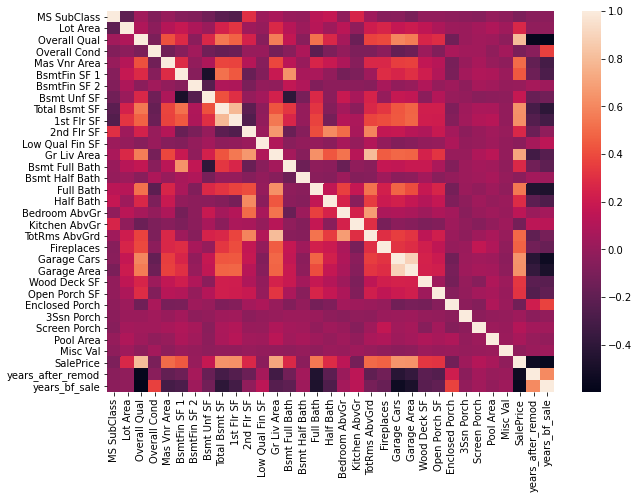

In [346]:
plt.figure(figsize=(10,7))
sns.heatmap(numerical_cols_corr)
plt.show()

The Price Sale column has strong correlations with Overall Qual and Gr Liv Area columns.

In [347]:
numerical_saleprice_corr = numerical_cols.corr()['SalePrice'].abs().sort_values()
numerical_saleprice_corr

BsmtFin SF 2         0.006127
Misc Val             0.019273
3Ssn Porch           0.032268
Bsmt Half Bath       0.035875
Low Qual Fin SF      0.037629
Pool Area            0.068438
MS SubClass          0.085128
Overall Cond         0.101540
Screen Porch         0.112280
Kitchen AbvGr        0.119760
Enclosed Porch       0.128685
Bedroom AbvGr        0.143916
Bsmt Unf SF          0.182751
Lot Area             0.267520
2nd Flr SF           0.269601
Bsmt Full Bath       0.276258
Half Bath            0.284871
Open Porch SF        0.316262
Wood Deck SF         0.328183
BsmtFin SF 1         0.439284
Fireplaces           0.474831
TotRms AbvGrd        0.498574
Mas Vnr Area         0.506983
years_after_remod    0.534985
Full Bath            0.546118
years_bf_sale        0.558979
1st Flr SF           0.635185
Garage Area          0.641425
Total Bsmt SF        0.644012
Garage Cars          0.648361
Gr Liv Area          0.717596
Overall Qual         0.801206
SalePrice            1.000000
Name: Sale

In [348]:
# drop columns with the correlation < 0.4 (arbitary value)
ames.drop(columns = numerical_saleprice_corr[numerical_saleprice_corr < 0.4].index, inplace = True)

### 3.2 Convert the columns of nominal variables to categorical

In [349]:
obj_columns = ames.select_dtypes(include = 'object')

Before the conversion, we need to find number of unique values for each column. If the number of unique values is more than 10 (an arbitary number and you can change this to other number), we will drop that column since later on after converting these columns to catgories, there will be too many columns adding to our data.

In [350]:
obj_col_unique = {}
for col in obj_columns.columns:
    unique_vals = ames[col].unique()
    obj_col_unique[col] = len(unique_vals)

# find the columns with unique values > 10
drop_cols = []
for col, num in obj_col_unique.items():
    if num > 10:
        drop_cols.append(col)

In [351]:
# drop the columns with unique value > 10
ames.drop(columns = drop_cols, inplace = True)

Next step before the conversion is to (1) find whether there is any column with more than 95% of the values of that column belong to a certain category, and (2) drop that column. The reason why we drop this type of column is because there will be no or less variability in the data for the model to capture.

In [352]:
nominal = ames.select_dtypes(include = 'object')

In [353]:
nominal_unique_pct = {}
for col in nominal.columns:
    nominal_unique_pct[col] = nominal[col].value_counts(normalize=True).values

# Find the columns with less variability or 95% of the values is in a specific category
drop_cols = []
for col, vals in nominal_unique_pct.items():
    max_pct = max(vals)
    if max_pct > 0.95:
        drop_cols.append(col)

In [354]:
# drop the columns
ames.drop(columns = drop_cols, inplace = True)

Next, let's convert the nominal columns to categorical.

In [355]:
nominal_cols = ames.select_dtypes(include = 'object')

for col in nominal_cols.columns:
    ames[col] = ames[col].astype('category')

# concatenate the dummy columns back to ames and delete the original columns
for col in nominal_cols.columns:
    ames = pd.concat([ames, pd.get_dummies(ames[col])], axis = 1)
    del ames[col]

In [356]:
ames.head()

,Overall Qual,Mas Vnr Area,BsmtFin SF 1,Total Bsmt SF,1st Flr SF,Gr Liv Area,Full Bath,TotRms AbvGrd,Fireplaces,Garage Cars,...,Maj2,Min1,Min2,Mod,Sal,Sev,Typ,N,P,Y
0,6,112.0,639.0,1080.0,1656,1656,1,7,2,2.0,...,0,0,0,0,0,0,1,0,1,0
1,5,0.0,468.0,882.0,896,896,1,5,0,1.0,...,0,0,0,0,0,0,1,0,0,1
2,6,108.0,923.0,1329.0,1329,1329,1,6,0,1.0,...,0,0,0,0,0,0,1,0,0,1
3,7,0.0,1065.0,2110.0,2110,2110,2,8,2,2.0,...,0,0,0,0,0,0,1,0,0,1
4,5,0.0,791.0,928.0,928,1629,2,6,1,2.0,...,0,0,0,0,0,0,1,0,0,1


## 4. Train and Test

In [373]:
target = 'SalePrice'
features = ames.drop(columns = target).columns

model = LinearRegression()
kf = KFold(n_splits = 10, shuffle=True)
rmses = []

for train_index, test_index in kf.split(ames):
    train = ames.iloc[train_index]
    test = ames.iloc[test_index]
    model.fit(train[features], train[target])
    prediction = model.predict(test[features])
    rmse = np.sqrt(mean_squared_error(test[target], prediction))
    rmses.append(rmse)
print('Average RMSE: ', np.mean(rmses))

Average RMSE:  28391.457173488492


## 5. Combine all the methods and build functions

In [358]:
def transform_features(df):
    # 1. drop all columns' missing values
    df_null = df.isnull().sum()*100/len(df)
    df_5pct_null = df_null[df_null > 5]
    df.drop(columns = df_5pct_null.index, inplace = True)
    
    # 2. drop object/text columns witth missing values
    df_text_null = df.select_dtypes(include = ['object']).isnull().sum()
    df_text_null = df_text_null[df_text_null > 0]
    df.drop(columns = df_text_null.index, inplace = True)
    
    # 3. Replace null in numerical columns with common values
    numerical = df.select_dtypes(include = ['int', 'float'])
    numerical_null = df.isnull().sum() > 0
    numerical_null = numerical_null[numerical_null]
    
    for col in numerical_null.index:
        df[col].fillna(df[col].mode()[0], inplace=True)
    
    # 4. Create new features and drop original columns
    df['years_after_remod'] = df['Yr Sold'] - df['Year Remod/Add']
    df.drop(df[df['years_after_remod'] < 0].index, inplace = True)
    
    df['years_bf_sale'] = df['Yr Sold'] - df['Year Built']
    df.drop(df[df['years_bf_sale'] < 0].index, inplace = True)
    df.drop(columns=['Year Remod/Add','Year Built', 'Yr Sold'], inplace=True)
    
    # 5. remove unnescessary columns
    df.drop(columns = ['Order', 'PID'], inplace = True)
    df.drop(columns = ['Mo Sold', 'Sale Type', 'Sale Condition'], inplace = True)
    
    return df

In [359]:
def select_features(df, min_correlation=0.4, unique_threshold=10):
    # 1. select numerical columns with a high corelation to Sale Price 
    #(drop the columns with correlations are less than the assigned minimum correlation)
    numerical_cols = df.select_dtypes(include = ['int', 'float'])
    numerical_saleprice_corr = numerical_cols.corr()['SalePrice'].abs().sort_values()
    df.drop(columns = numerical_saleprice_corr[numerical_saleprice_corr < min_correlation].index, inplace = True)
    
    # 2. convert nominal columns to categorical
    obj_columns = df.select_dtypes(include = 'object')
    obj_col_unique = {}
    for col in obj_columns.columns:
        unique_vals = df[col].unique()
        obj_col_unique[col] = len(unique_vals)

    # find and drop the columns with unique values > unique threshold
    drop_cols = []
    for col, num in obj_col_unique.items():
        if num > unique_threshold:
            drop_cols.append(col)
    df.drop(columns = drop_cols, inplace = True)
    
    # remove column with low variability
    nominal = df.select_dtypes(include = 'object')
    nominal_unique_pct = {}
    for col in nominal.columns:
        nominal_unique_pct[col] = nominal[col].value_counts(normalize=True).values

    # Find and drop the columns with less variability or 95% of the values is in a specific category
    drop_cols = []
    for col, vals in nominal_unique_pct.items():
        max_pct = max(vals)
        if max_pct > 0.95:
            drop_cols.append(col)
    df.drop(columns = drop_cols, inplace = True)
    
    # convert the nominal columns to categorical
    nominal_cols = df.select_dtypes(include = 'object')

    for col in nominal_cols.columns:
        df[col] = df[col].astype('category')

    # concatenate the dummy columns back to ames and delete the original columns
    for col in nominal_cols.columns:
        df = pd.concat([df, pd.get_dummies(df[col])], axis = 1)
        del df[col]

    return df

In [360]:
def train_and_test(df, k=2):
    target = 'SalePrice'
    features = df.drop(columns = target).columns

    model = LinearRegression()
    kf = KFold(n_splits = k, shuffle=True)
    rmses = []

    for train_index, test_index in kf.split(df):
        train = df.iloc[train_index]
        test = df.iloc[test_index]
        model.fit(train[features], train[target])
        prediction = model.predict(test[features])
        rmse = np.sqrt(mean_squared_error(test[target], prediction))
        rmses.append(rmse)
    return np.mean(rmses)

In [369]:
def plot_rmse(selected_df,label):
    rmses = {}
    for k in range(2,21):
        rmses[k] = train_and_test(selected_df, k)
    
    x = []
    y = []
    for k, rmse in rmses.items():
        x.append(k)
        y.append(rmse)
    fig = plt.figure(figsize = (10,5))
    plt.plot(x,y, label=label)
    plt.xlabel('fold number')
    plt.ylabel('RMSE')
    plt.xticks(np.arange(1,21,1))
    plt.legend()

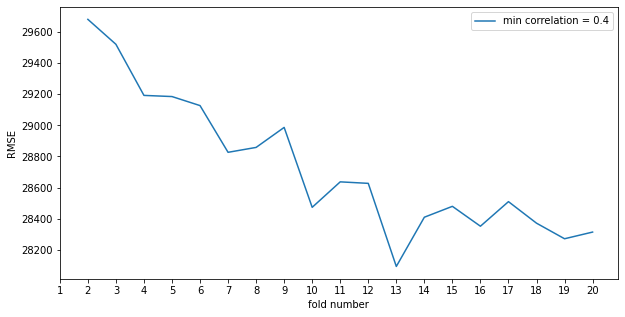

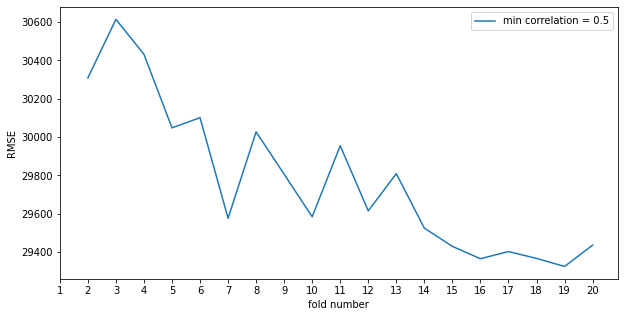

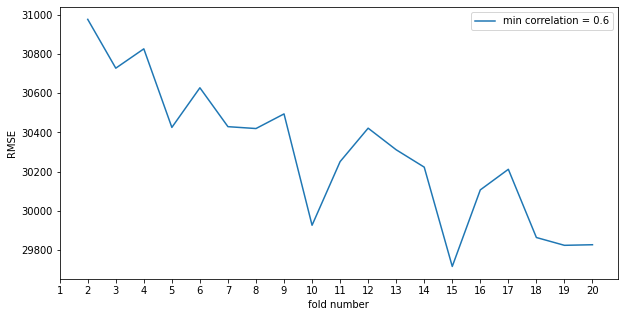

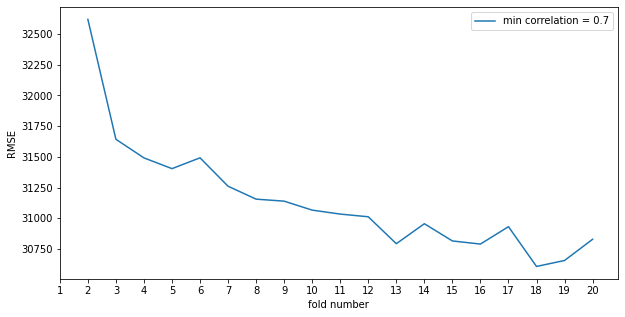

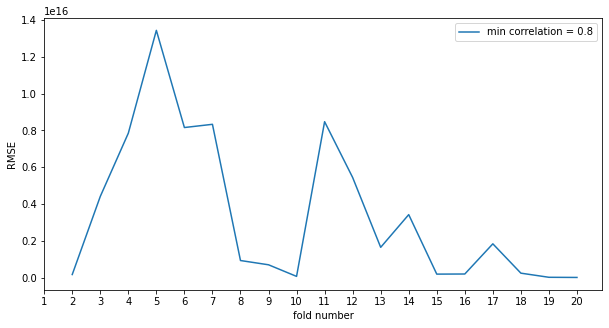

In [370]:
data = pd.read_csv("AmesHousing.tsv", delimiter="\t")
min_corr = [0.4, 0.5, 0.6, 0.7, 0.8]
for mc in min_corr:
    df = data.copy()
    transforms = transform_features(df)
    selected = select_features(transforms, mc, 10)
    plot_rmse(selected,'min correlation = {}'.format(mc))

The minimum correlation that provides lower values of RMSE ranges is 0.4. The RMSE ranges get higher as we increase the minimum correlation used for the feature selection. Also, for the minimum correlation = 0.4, when we assign the fold number equal to 13, the average RMSE seems to be the lowest (~28672). However, if we divide the dataset to 13 folds, we will have a test set that is ~ 7% of the total dataset. This number appears to be pretty low. Thus, the optimal fold number seems to be 10 since (1) this will provide 90% train and 10% test sets, which is better than dividing the dataset to 13 folds, and (2) the RMSE is relatively low.